In [65]:
from sklearn.linear_model import LinearRegression # I will be using multiple linear regression as one method to evaluate the dataset and make predictions.
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import numpy as np
from seaborn import load_dataset, pairplot
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing
import pydot
import warnings
warnings.filterwarnings('ignore')

In [66]:
#def main():

basic_info = pd.read_csv('basics.tsv', sep = '\t')
rating_info = pd.read_csv('ratings.tsv', sep = '\t')

print(basic_info.shape)
print(rating_info.shape)

master_df = pd.merge(rating_info, basic_info, on = ["tconst"]) # We must join the basics and ratings tables on the unique movie ID ('tconst').
print(master_df.shape)

#if __name__ == '__main__':
#	main()

(9813254, 9)
(1307201, 3)
(1307199, 11)


In [67]:
 # Let's take a look at some of our data.

print(master_df.head)

# endYear seems to be exclusively newline values. We will remove that column.
working_df = master_df.copy()
working_df = working_df.drop("endYear", axis = 1)
working_df = working_df.drop("tconst", axis = 1)

# Other columns, mainly startYear, runtimeMinutes, and genres seem to have some newline values. Let's remove the rows that have these values.
remove_newlines = working_df[working_df["startYear"] == '\\N'].index
working_df.drop(remove_newlines, inplace = True)

remove_newlines = working_df[working_df["runtimeMinutes"] == '\\N'].index
working_df.drop(remove_newlines, inplace = True)

remove_newlines = working_df[working_df["genres"] == '\\N'].index
working_df.drop(remove_newlines, inplace = True)

remove_newlines = working_df[working_df["numVotes"] == '\\N'].index
working_df.drop(remove_newlines, inplace = True)

print(working_df.shape)


<bound method NDFrame.head of             tconst        averageRating  numVotes  titleType  \
0        tt0000001                 5.70      1966      short   
1        tt0000002                 5.80       264      short   
2        tt0000003                 6.50      1809      short   
3        tt0000004                 5.60       178      short   
4        tt0000005                 6.20      2608      short   
...            ...                  ...       ...        ...   
1307194  tt9916730                 8.30        10      movie   
1307195  tt9916766                 7.00        21  tvEpisode   
1307196  tt9916778                 7.20        36  tvEpisode   
1307197  tt9916840                 8.80         6  tvEpisode   
1307198  tt9916880                 8.20         6  tvEpisode   

                       primaryTitle               originalTitle isAdult  \
0                        Carmencita                  Carmencita       0   
1            Le clown et ses chiens      Le clown e

In [68]:
# Now we must convert some of the columns to numerical values. The first column to change is titleType.
print(working_df.nunique()) # There are 10 unique titleTypes.

title_types = set(working_df["titleType"])
print(title_types) # {'movie', 'tvMovie', 'tvSpecial', 'videoGame', 'tvShort', 'tvEpisode', 'short', 'tvSeries', 'video', 'tvMiniSeries'}

title_dictionary = {'movie' : 0, 'tvMovie' : 1, 'tvSpecial' : 2, 'videoGame' : 3, 'tvShort' : 4, 'tvEpisode' : 5, 
                    'short' : 6, 'tvSeries' : 7, 'video' : 8, 'tvMiniSeries' : 9}
working_df['titleType'] = working_df['titleType'].apply(lambda x: title_dictionary[x])

title_types = set(working_df["titleType"])
print(title_types)


averageRating         91
numVotes           21111
titleType             10
primaryTitle      717510
originalTitle     731461
isAdult                4
startYear            144
runtimeMinutes       712
genres              1949
dtype: int64
{'short', 'tvSpecial', 'tvShort', 'videoGame', 'video', 'tvEpisode', 'tvMiniSeries', 'tvSeries', 'movie', 'tvMovie'}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [69]:
# isAdult is supposed to be a boolean field yet it has 4 different values. Let's see what is happening here.

isAdult_types = set(working_df["isAdult"])
print(isAdult_types) # {0, 1, '0', '1'}

isAdult_dictionary = {0 : 0, '0': 0, 1 : 1, '1' : 1}
working_df['isAdult'] = working_df['isAdult'].apply(lambda x: isAdult_dictionary[x])

isAdult_types = set(working_df["isAdult"])
print(isAdult_types)


{0, 1, '0', '1'}
{0, 1}


In [70]:
# The genres feature has 1,949 unique values. It is very impractical to go through all 1,949 different values and create a dictionary.
# However, we can still use the feature. Let us determine how many genres a work has and change the field to represent that.
# We can do this by counting the number of commas in each entry. The max number of genres is 3.

print(working_df.shape)
genre_numbers = []
for row in working_df.itertuples():
  genre_list = row[-1].split(",")

  if len(genre_list) == 1:
    genre_numbers.append(1)

  elif len(genre_list) == 2:
    genre_numbers.append(2)

  else:
    genre_numbers.append(3)

working_df = working_df.drop("genres", axis = 1)
working_df['genres'] = genre_numbers
genre_types = set(working_df["genres"])
print(genre_types)
print(working_df.shape)
print(working_df.head)

(925526, 9)
{1, 2, 3}
(925526, 9)
<bound method NDFrame.head of                averageRating  numVotes  titleType  \
0                       5.70      1966          6   
1                       5.80       264          6   
2                       6.50      1809          6   
3                       5.60       178          6   
4                       6.20      2608          6   
...                      ...       ...        ...   
1307191                 9.20         6          5   
1307192                 8.10         9          5   
1307195                 7.00        21          5   
1307197                 8.80         6          5   
1307198                 8.20         6          5   

                               primaryTitle  \
0                                Carmencita   
1                    Le clown et ses chiens   
2                            Pauvre Pierrot   
3                               Un bon bock   
4                          Blacksmith Scene   
...              

In [71]:
# There are two more fields we can either modify or remove: primaryTitle and originalTitle.
# If we knew for sure how many languages are represented in the dataset it could be interesting to use the bigram model
# and change the originalTitle column to represent the language of the title of the film. That, however, would take weeks to develop ourselves.
# We can create a new column which represents the length of the title in characters and see if it is a meaningful feature.
# As the primaryTitle and originalTitle are often the same, we will just take the length of the primaryTitle.

length_of_titles = []

for row in working_df.itertuples():
  length_of_titles.append(len(row[-6]))


working_df = working_df.drop("primaryTitle", axis = 1)
working_df = working_df.drop("originalTitle", axis = 1)

working_df["length_title"] = length_of_titles
print(working_df.shape)
print(working_df.head)

(925526, 8)
<bound method NDFrame.head of                averageRating  numVotes  titleType  isAdult startYear  \
0                       5.70      1966          6        0      1894   
1                       5.80       264          6        0      1892   
2                       6.50      1809          6        0      1892   
3                       5.60       178          6        0      1892   
4                       6.20      2608          6        0      1893   
...                      ...       ...        ...      ...       ...   
1307191                 9.20         6          5        0      2012   
1307192                 8.10         9          5        0      2012   
1307195                 7.00        21          5        0      2019   
1307197                 8.80         6          5        0      2014   
1307198                 8.20         6          5        0      2014   

        runtimeMinutes  genres  length_title  
0                    1       2            10  

             averageRating             numVotes            titleType  \
count           925,526.00           925,526.00           925,526.00   
mean                  6.87             1,439.85                 3.82   
std                   1.34            20,673.42                 2.68   
min                   1.00                 5.00                 0.00   
25%                   6.10                14.00                 0.00   
50%                   7.10                37.00                 5.00   
75%                   7.80               161.00                 5.00   
max                  10.00         2,732,085.00                 9.00   

                   isAdult               genres         length_title  
count           925,526.00           925,526.00           925,526.00  
mean                  0.02                 2.03                18.33  
std                   0.13                 0.83                10.95  
min                   0.00                 1.00                 1.0

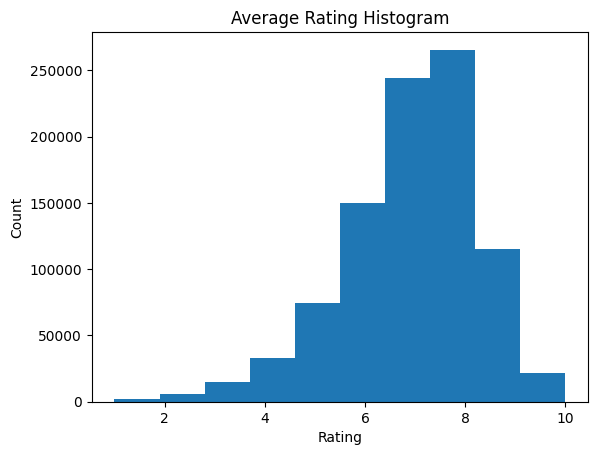

0                        -0.87
1                        -0.80
2                        -0.27
3                        -0.95
4                        -0.50
                  ...         
1307191                   1.75
1307192                   0.92
1307195                   0.10
1307197                   1.45
1307198                   1.00
Name: averageRating, Length: 925526, dtype: float64
             averageRating             numVotes            titleType  \
count           916,779.00           916,779.00           916,779.00   
mean                  6.91             1,447.85                 3.82   
std                   1.26            20,767.50                 2.68   
min                   2.90                 5.00                 0.00   
25%                   6.20                14.00                 0.00   
50%                   7.10                37.00                 5.00   
75%                   7.80               160.00                 5.00   
max                  10.00     

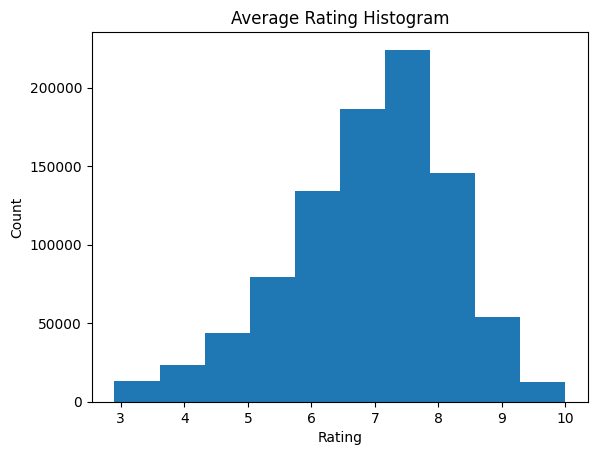

In [72]:
# Let's perform some exploratory data analysis to remove outliers and see what the features look like.
# Let's start with some histograms of the features.
import scipy.stats as stats
print(working_df.describe())

plt.hist(working_df["averageRating"])
plt.title("Average Rating Histogram")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# There is left skew in the histogram. The majority of works are rated between 6.0 and 8.0 it seems.
# Some works have a rating as low as a 1.0. Let's calculate some z-scores and remove some extreme outliers.
zscores = stats.zscore(working_df["averageRating"])
print(zscores)
# The vast majority of values are within three standard deviations of the mean. Let's remove any work with a value over three SD's away.

working_df["zscores"] = zscores

rating_remove = working_df[working_df["zscores"] < -3].index # We do not account for cases where the zscore > 3 SD's away as that would be a rating of over 10.0.
working_df.drop(rating_remove, inplace = True)
working_df = working_df.drop("zscores", axis = 1)
print(working_df.describe())

plt.hist(working_df["averageRating"])
plt.title("Average Rating Histogram")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show() # There is still left skew but this looks better.


             averageRating             numVotes            titleType  \
count           916,779.00           916,779.00           916,779.00   
mean                  6.91             1,447.85                 3.82   
std                   1.26            20,767.50                 2.68   
min                   2.90                 5.00                 0.00   
25%                   6.20                14.00                 0.00   
50%                   7.10                37.00                 5.00   
75%                   7.80               160.00                 5.00   
max                  10.00         2,732,085.00                 9.00   

                   isAdult               genres         length_title  
count           916,779.00           916,779.00           916,779.00  
mean                  0.02                 2.03                18.33  
std                   0.13                 0.83                10.95  
min                   0.00                 1.00                 1.0

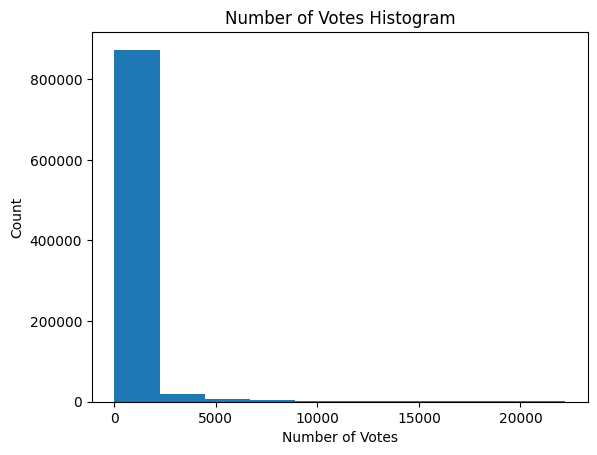

             averageRating             numVotes            titleType  \
count           908,772.00           908,772.00           908,772.00   
mean                  6.91               385.86                 3.84   
std                   1.26             1,470.18                 2.67   
min                   2.90                 5.00                 0.00   
25%                   6.20                14.00                 0.00   
50%                   7.10                36.00                 5.00   
75%                   7.80               152.00                 5.00   
max                  10.00            22,212.00                 9.00   

                   isAdult               genres         length_title  
count           908,772.00           908,772.00           908,772.00  
mean                  0.02                 2.03                18.36  
std                   0.13                 0.83                10.97  
min                   0.00                 1.00                 1.0

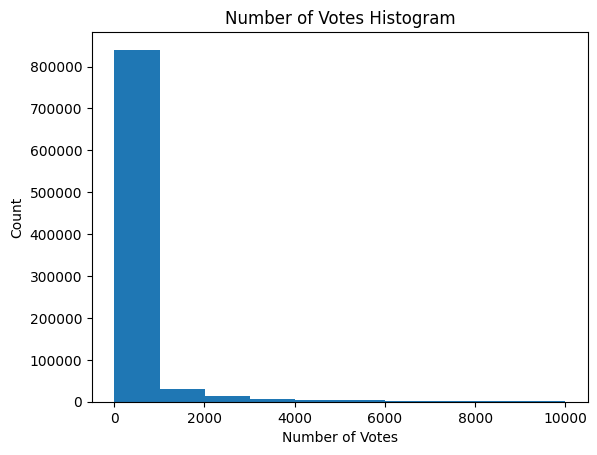

             averageRating             numVotes            titleType  \
count           903,074.00           903,074.00           903,074.00   
mean                  6.91               295.14                 3.86   
std                   1.26               887.24                 2.66   
min                   2.90                 5.00                 0.00   
25%                   6.20                14.00                 0.00   
50%                   7.10                36.00                 5.00   
75%                   7.80               147.00                 5.00   
max                  10.00            10,000.00                 9.00   

                   isAdult               genres         length_title  
count           903,074.00           903,074.00           903,074.00  
mean                  0.02                 2.02                18.38  
std                   0.13                 0.83                10.98  
min                   0.00                 1.00                 1.0

In [73]:
# Now let's check the numVotes column.
pd.options.display.float_format = '{:20,.2f}'.format # Disabling scientific notation.
print(working_df.describe())
# The max and min values are *very* far apart (the SD is 20,767.50!). The max is so high that pandas was using scientific notation.
# I disabled this but matplotlib is also having trouble graphing because of this.
# We are going to have to remove some of the extreme outliers before graphing. Let's use z-scores again.
# The 75% quartile is 160 votes. So the SD is very likely skewed by the outliers. Let's remove values that are > 1 SD away.

zscores = stats.zscore(working_df["numVotes"])
print(zscores)

working_df["zscores"] = zscores

votes_remove = working_df[working_df["zscores"] > 1].index
working_df.drop(votes_remove, inplace = True)
working_df = working_df.drop("zscores", axis = 1)


print(working_df["numVotes"])
plt.hist(working_df["numVotes"])
plt.title("Number of Votes Histogram")
plt.xlabel("Number of Votes")
plt.ylabel("Count")
plt.show() # There is extreme left skew. The SD is now 1,470.18. So few of the rows have a numVotes > 10,000 and they are further skewing the graph. Let's remove them.
print(working_df.describe())


votes_remove = working_df[working_df["numVotes"] > 10000].index
working_df.drop(votes_remove, inplace = True)

print(working_df["numVotes"])
plt.hist(working_df["numVotes"])
plt.title("Number of Votes Histogram")
plt.xlabel("Number of Votes")
plt.ylabel("Count")
plt.show()

print(working_df.describe()) # The SD is now 887.24. If problems persist we will further remove values.

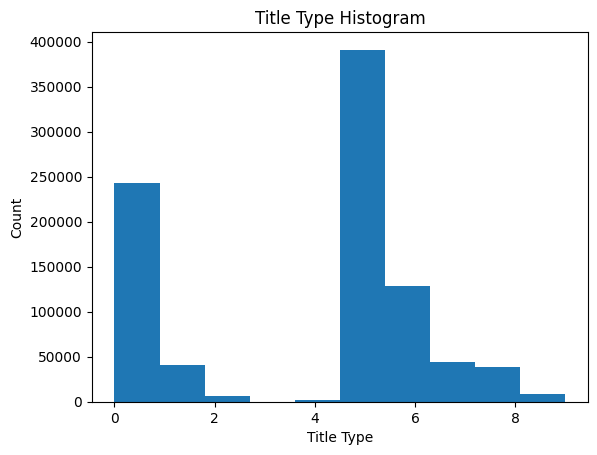

5    390898
0    242505
6    128962
7     44314
1     41200
8     38565
9      8115
2      6445
4      1987
3        83
Name: titleType, dtype: int64
3    390898
0    242505
4    128962
5     44314
1     41200
6     38565
7      8115
2      6445
Name: titleType, dtype: int64


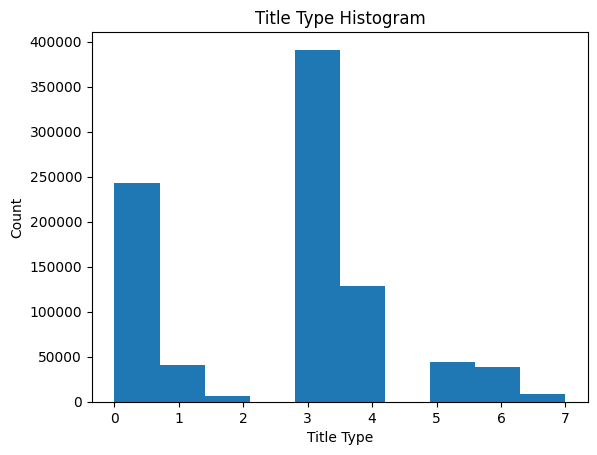

             averageRating             numVotes            titleType  \
count           901,004.00           901,004.00           901,004.00   
mean                  6.91               295.52                 2.50   
std                   1.26               887.95                 1.80   
min                   2.90                 5.00                 0.00   
25%                   6.20                14.00                 0.00   
50%                   7.10                36.00                 3.00   
75%                   7.80               147.00                 3.00   
max                  10.00            10,000.00                 7.00   

                   isAdult               genres         length_title  
count           901,004.00           901,004.00           901,004.00  
mean                  0.02                 2.02                18.37  
std                   0.13                 0.83                10.97  
min                   0.00                 1.00                 1.0

In [74]:
# Let's examine the titleType column. As a reminder, the significance of the numbers are:
# {'movie' : 0, 'tvMovie' : 1, 'tvSpecial' : 2, 'videoGame' : 3, 'tvShort' : 4, 'tvEpisode' : 5, 
#                    'short' : 6, 'tvSeries' : 7, 'video' : 8, 'tvMiniSeries' : 9}

#print(working_df["titleType"])
plt.hist(working_df["titleType"])
plt.title("Title Type Histogram")
plt.xlabel("Title Type")
plt.ylabel("Count")
plt.show() # It looks like there are very few works of type 3 and 4. Let's see the count of each.

print(working_df["titleType"].value_counts()) # There are only 83 of type 3 and 1,987 of type 4. Let's remove these and update the values. All other types have > 6,400 entries.

remove_type_three = working_df[working_df["titleType"] == 3].index
working_df.drop(remove_type_three, inplace = True)

remove_type_four = working_df[working_df["titleType"] == 4].index
working_df.drop(remove_type_four, inplace = True)

working_df["titleType"].replace(5, 3, inplace = True)
working_df["titleType"].replace(6, 4, inplace = True)
working_df["titleType"].replace(7, 5, inplace = True)
working_df["titleType"].replace(8, 6, inplace = True)
working_df["titleType"].replace(9, 7, inplace = True)
print(working_df["titleType"].value_counts())

plt.hist(working_df["titleType"])
plt.title("Title Type Histogram")
plt.xlabel("Title Type")
plt.ylabel("Count")
plt.show()

print(working_df.describe())

In [75]:
# The isAdult column refers to whether or not a work is an "adult title" (which is a bit ambiguous). 0 for no, 1 for yes.

print(working_df["isAdult"].value_counts())

print("Percentage of titles that are 'adult titles': ", str(100 * (14846 / (14846 + 886158))) + "%")

# There is extreme imbalance here. We will perform tests when the model is fit to see if this feature should be kept.

0    886158
1     14846
Name: isAdult, dtype: int64
Percentage of titles that are 'adult titles':  1.6477174352167137%


3    322759
1    302893
2    275352
Name: genres, dtype: int64


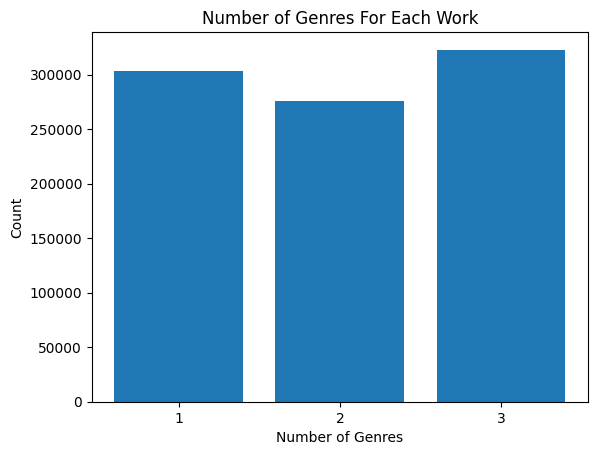

In [76]:
# Let's see the count for the genres column which we created earlier.

print(working_df["genres"].value_counts())
x_values = [1,2,3]
y_values = [302893, 275352, 322759]
plt.bar(x_values, y_values)
plt.title("Number of Genres For Each Work")
plt.xlabel("Number of Genres")
plt.ylabel("Count")
plt.xticks(np.arange(min(x_values), max(x_values)+1, 1.0))
plt.show() # This looks pretty normal and evenly distributed.

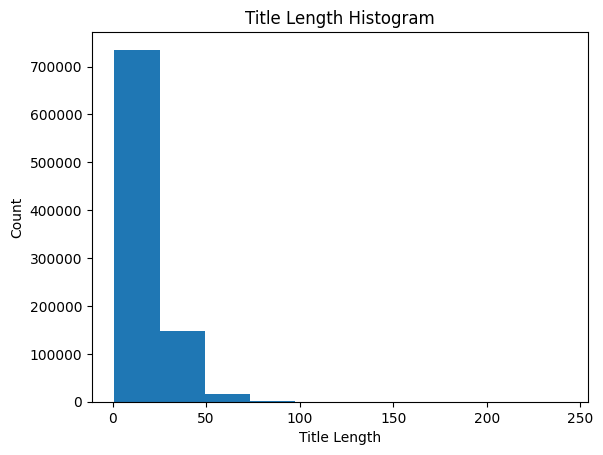

0                        -0.76
1                         0.33
2                        -0.40
3                        -0.67
4                        -0.22
                  ...         
1307191                   1.42
1307192                   1.06
1307195                  -0.40
1307197                   0.70
1307198                   0.60
Name: length_title, Length: 901004, dtype: float64


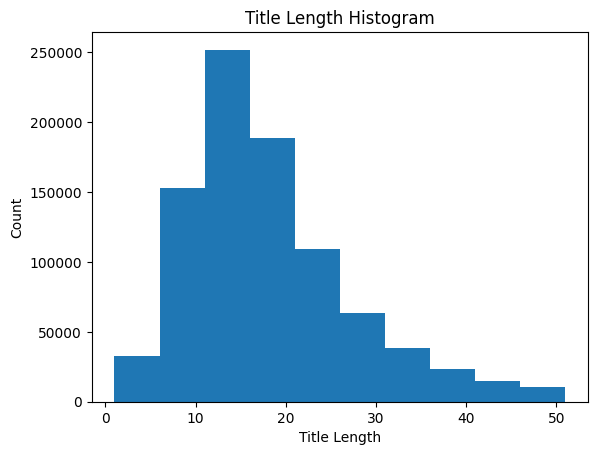

             averageRating             numVotes            titleType  \
count           885,527.00           885,527.00           885,527.00   
mean                  6.91               298.35                 2.49   
std                   1.26               893.26                 1.80   
min                   2.90                 5.00                 0.00   
25%                   6.20                14.00                 0.00   
50%                   7.10                36.00                 3.00   
75%                   7.80               149.00                 3.00   
max                  10.00            10,000.00                 7.00   

                   isAdult               genres         length_title  
count           885,527.00           885,527.00           885,527.00  
mean                  0.02                 2.02                17.58  
std                   0.13                 0.83                 9.10  
min                   0.00                 1.00                 1.0

In [77]:
# The final feature to examine is length_title. This is a fairly straightforward reduction.
# Z-scores will be used again to eliminate outliers.

plt.hist(working_df["length_title"])
plt.title("Title Length Histogram")
plt.xlabel("Title Length")
plt.ylabel("Count")
plt.show() # Extreme right skew.

zscores = stats.zscore(working_df["length_title"])
print(zscores)

working_df["zscores"] = zscores

length_remove = working_df[working_df["zscores"] > 3].index
working_df.drop(length_remove, inplace = True)
working_df = working_df.drop("zscores", axis = 1)

plt.hist(working_df["length_title"])
plt.title("Title Length Histogram")
plt.xlabel("Title Length")
plt.ylabel("Count")
plt.show() # There is still some right skew but otherwise this looks like a reasonable distriubtion.

print(working_df.describe()) # The final dataset has 885,527 rows and 6 columns.

In [82]:
# Let's start with a multiple linear regression model. The target is of course averageRating and the features are all other columns.
#from sklearn import linear_model
import statsmodels.api as sm
working_df["startYear"] = pd.to_numeric(working_df["startYear"])
working_df["runtimeMinutes"] = pd.to_numeric(working_df["runtimeMinutes"])
x = working_df.drop('averageRating', axis = 1)
y = working_df['averageRating']


#add constant to predictor variables
#x -= np.average(x)
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary()) # The R-Squared is 0.095 and none of the features seem to be very important. Let us check for collinearity.

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                 1.330e+04
Date:                Wed, 03 May 2023   Prob (F-statistic):               0.00
Time:                        04:00:35   Log-Likelihood:            -1.4191e+06
No. Observations:              885527   AIC:                         2.838e+06
Df Residuals:                  885519   BIC:                         2.838e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -8.2366      0.117    -70.